In [2]:
import numpy as np
import os
import cv2
import random
from PIL import Image
import tensorflow as tf
from keras.applications.resnet import ResNet152, ResNet50, ResNet101
from keras.models import Model
from sklearn.utils import shuffle
from sklearn import decomposition, svm
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import (
    Conv2D,
    MaxPool2D,
    Flatten,
    Dense,
    InputLayer,
    Activation,
    BatchNormalization,
    GlobalAveragePooling2D,
    Dropout,
)
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [3]:
def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

input_shape = (465, 930, 3)

# Define hyperparameters and their values for GridSearch
param_grid = {
    'learning_rate': [0.0001, 0.001],
    'hidden_layers': [1, 2],
}

combinations = [[0,0], [0,1], [1,0], [1,1]]

# Define hyperparameters and their values for GridSearch
param_grid2 = {
    'learning_rate': [0.0001, 0.001],
    'dropout_rate':  [0, 0.2],
    'hidden_layers': [1, 2],
}

combinations2 = [[0,0,0], [0,0,1], [0,1,0], [0,1,1], [1,0,0], [1,0,1], [1,1,0], [1,1,1]]

# Preprocessing data

### Batches:

In [4]:
train_path = "rp_data/train"
valid_path = "rp_data/valid"
test_path = "rp_data/test"

# Define image size and number of channels
img_height = 465
img_width = 930

# Change preprocess_input to the corresponding classifier (vgg16, resnet etc.)
train_batches = ImageDataGenerator(
    tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory=train_path,
    target_size=(img_height, img_width),
    classes=["normal", "stroke"],
    batch_size=16,
)

valid_batches = ImageDataGenerator(
    tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory=valid_path,
    target_size=(img_height, img_width),
    classes=["normal", "stroke"],
    batch_size=16,
)
test_batches = ImageDataGenerator(
    tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory=test_path,
    target_size=(img_height, img_width),
    classes=["normal", "stroke"],
    batch_size=16,
    shuffle=False,
)

Found 3537 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


### Numpy arrays:

In [16]:
# Using numpy arrays instead:

train_path_normal = "rp_data/train/normal"
train_path_stroke = "rp_data/train/stroke"
valid_path_normal = "rp_data/valid/normal"
valid_path_stroke = "rp_data/valid/stroke"
test_path_normal = "rp_data/test/normal"
test_path_stroke = "rp_data/test/stroke"

# Define image size and number of channels
height = 465
width = 930

# --- Training dataset --- #

train_images = []
train_labels = []

for filename in os.listdir(train_path_normal):
    # Load the image using PIL
    img = Image.open(os.path.join(train_path_normal, filename)).convert('L')
    # Convert the image to a numpy array and append to train_images array
    train_images.append(np.array(img).astype(np.float32)/255.)
    # Append the label to the train_labels list
    train_labels.append(0)

for filename in os.listdir(train_path_stroke):
    # Load the image using PIL
    img = Image.open(os.path.join(train_path_stroke, filename)).convert('L')
    # Convert the image to a numpy array and append to train_images array
    train_images.append(np.array(img).astype(np.float32)/255.)
    # Append the label to the train_labels list
    train_labels.append(1)

train_images = np.array(train_images)
train_labels = np.array(train_labels)
train_images = train_images[0].reshape(height, width)

num_classes = len(np.unique(train_labels))
print("Number of unique classes:", num_classes)
print("Training images and labels:", train_images.shape, train_labels.shape)

# Shuffle:

# Combine the train_images and train_labels list using zip
combined = list(zip(train_images, train_labels))
# Shuffle the combined list
random.shuffle(combined)
# Separate the shuffled images and labels list
train_images, train_labels = zip(*combined)
train_images = np.array(train_images)
train_labels = np.array(train_labels)

#print(train_labels, train_images)


Number of unique classes: 2
Training images and labels: (465, 930) (3537,)


In [17]:
# --- Validation dataset --- #

valid_images = []
valid_labels = []

for filename in os.listdir(valid_path_normal):
    # Load the image using PIL
    img = Image.open(os.path.join(valid_path_normal, filename)).convert('L')
    # Convert the image to a numpy array and append to train_images array
    valid_images.append(np.array(img).astype(np.float32)/255.)
    # Append the label to the train_labels list
    valid_labels.append(0)

for filename in os.listdir(valid_path_stroke):
    # Load the image using PIL
    img = Image.open(os.path.join(valid_path_stroke, filename)).convert('L')
    # Convert the image to a numpy array and append to train_images array
    valid_images.append(np.array(img).astype(np.float32)/255.)
    # Append the label to the train_labels list
    valid_labels.append(1)

valid_images = np.array(valid_images)
valid_labels = np.array(valid_labels)
valid_images = valid_images[0].reshape(height, width)

num_classes = len(np.unique(valid_labels))
print("Number of unique classes:", num_classes)

print("Validation images and labels:", valid_images.shape, valid_labels.shape)

# Shuffle:

# Combine the train_images and train_labels list using zip
combined = list(zip(valid_images, valid_labels))
# Shuffle the combined list
random.shuffle(combined)
# Separate the shuffled images and labels list
valid_images, valid_labels = zip(*combined)
valid_images = np.array(valid_images)
valid_labels = np.array(valid_labels)

#print(valid_labels, valid_images)

Number of unique classes: 2
Validation images and labels: (465, 930) (585,)


In [13]:
# --- Test dataset --- #

test_images = []
test_labels = []

for filename in os.listdir(test_path_normal):
    # Load the image using PIL
    img = Image.open(os.path.join(test_path_normal, filename)).convert('L')
    # Convert the image to a numpy array and append to train_images array
    test_images.append(np.array(img).astype(np.float32)/255.)
    # Append the label to the train_labels list
    test_labels.append(0)

for filename in os.listdir(test_path_stroke):
    # Load the image using PIL
    img = Image.open(os.path.join(test_path_stroke, filename)).convert('L')
    # Convert the image to a numpy array and append to train_images array
    test_images.append(np.array(img).astype(np.float32)/255.)
    # Append the label to the train_labels list
    test_labels.append(1)

test_images = np.array(test_images)
test_labels = np.array(test_labels)
test_images = test_images[0].reshape(height, width)

print("Testing images and labels:", test_images.shape, test_labels.shape)

Testing images and labels: (465, 930) (51,)


# Custom CNN model

In [54]:
# TODO: Add more Dense layer neurons in the last hidden layer, increase the epoch size when the best hyperparameters are known.
# TODO: Also increase filers in the conv layers, kernel size too maybe and increase the batch size in the data batches to 64 or 128 perhaps to speed things up.
# TODO: + maybe not the vgg16 preprocess on the batches?

scores_customCNN = []
models_customCNN = []

for i in combinations:
    lr = param_grid['learning_rate'][i[0]]
    layers = param_grid['hidden_layers'][i[1]]
    print("Learning rate:", lr)
    print("Layers:", layers)

    model_customCNN = Sequential()
    
    model_customCNN.add(Conv2D(
            filters=32,
            kernel_size=(5, 5),
            activation="relu",
            padding="same",
            input_shape=(img_height, img_width, 3),
        ))
    model_customCNN.add(MaxPool2D(pool_size=(2, 2), strides=2))
    for i in range(layers):
        model_customCNN.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same"))
        model_customCNN.add(MaxPool2D(pool_size=(2, 2), strides=2))
    
    model_customCNN.add(GlobalAveragePooling2D())
    model_customCNN.add(Dense(64, activation="relu"))

    model_customCNN.add(Dense(units=2, activation="softmax"))


    model_customCNN.compile(
        optimizer=Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    model_customCNN.summary()
    
    model_customCNN.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)
    score = model_customCNN.evaluate(test_batches, verbose=0)

    print("Test loss: {}, Test accuracy {}".format(score[0], score[1]))

    scores_customCNN.append(score)
    models_customCNN.append(model_customCNN)

print(scores_customCNN)

Learning rate: 0.0001
Layers: 1
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 465, 930, 32)      2432      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 232, 465, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 232, 465, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 116, 232, 64)     0         
 2D)                                                             
                                                                 
 global_average_pooling2d_22  (None, 64)               0         
  (GlobalAveragePooling2D)                                       
                     

c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\keras\preprocessing\image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/10
222/222 - 385s - loss: 0.4985 - accuracy: 0.8015 - val_loss: 0.4187 - val_accuracy: 0.9197 - 385s/epoch - 2s/step
Epoch 2/10
222/222 - 390s - loss: 0.4078 - accuracy: 0.8230 - val_loss: 0.4299 - val_accuracy: 0.9179 - 390s/epoch - 2s/step
Epoch 3/10
222/222 - 387s - loss: 0.3899 - accuracy: 0.8312 - val_loss: 0.4040 - val_accuracy: 0.8650 - 387s/epoch - 2s/step
Epoch 4/10
222/222 - 370s - loss: 0.3657 - accuracy: 0.8439 - val_loss: 0.3793 - val_accuracy: 0.9179 - 370s/epoch - 2s/step
Epoch 5/10
222/222 - 365s - loss: 0.3635 - accuracy: 0.8504 - val_loss: 0.3999 - val_accuracy: 0.9145 - 365s/epoch - 2s/step
Epoch 6/10
222/222 - 365s - loss: 0.3521 - accuracy: 0.8490 - val_loss: 0.4944 - val_accuracy: 0.7214 - 365s/epoch - 2s/step
Epoch 7/10
222/222 - 365s - loss: 0.3409 - accuracy: 0.8519 - val_loss: 0.3633 - val_accuracy: 0.9128 - 365s/epoch - 2s/step
Epoch 8/10
222/222 - 364s - loss: 0.3209 - accuracy: 0.8671 - val_loss: 0.3531 - val_accuracy: 0.9368 - 364s/epoch - 2s/step


# Pretrained CNN model (VGG16)

In [4]:
scores_vgg16 = []
models_vgg16 = []

for i in combinations:
    lr = param_grid['learning_rate'][i[0]]
    layers = param_grid['hidden_layers'][i[1]]
    print("Learning rate:", lr)
    print("Layers:", layers)

    vgg16_model = tf.keras.applications.vgg16.VGG16()
    #vgg16_model.summary()

    modelVGG = Sequential()
    for layer in vgg16_model.layers[:-4]:
        modelVGG.add(layer)

    for layer in modelVGG.layers:
        layer.trainable = False

    modelVGG.add(GlobalAveragePooling2D())
    for i in range(layers):
        modelVGG.add(Dense(128, activation="relu"))
    
    modelVGG.add(Dense(units=2, activation="softmax"))

    modelVGG.compile(
        optimizer=Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    modelVGG.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=2)
    score = modelVGG.evaluate(test_batches, verbose=0)

    print("Test loss: {}, Test accuracy {}".format(score[0], score[1]))

    scores_vgg16.append(score)
    models_vgg16.append(modelVGG)

print(scores_vgg16)

Learning rate: 0.0001
Layers: 1
Epoch 1/5


c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\keras\preprocessing\image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


443/443 - 158s - loss: 0.3405 - accuracy: 0.8567 - val_loss: 0.3812 - val_accuracy: 0.8718 - 158s/epoch - 357ms/step
Epoch 2/5
443/443 - 140s - loss: 0.1322 - accuracy: 0.9525 - val_loss: 0.3959 - val_accuracy: 0.8513 - 140s/epoch - 316ms/step
Epoch 3/5
443/443 - 143s - loss: 0.0850 - accuracy: 0.9757 - val_loss: 0.3541 - val_accuracy: 0.8803 - 143s/epoch - 322ms/step
Epoch 4/5
443/443 - 141s - loss: 0.0573 - accuracy: 0.9890 - val_loss: 0.3607 - val_accuracy: 0.9009 - 141s/epoch - 319ms/step
Epoch 5/5
443/443 - 141s - loss: 0.0384 - accuracy: 0.9972 - val_loss: 0.3861 - val_accuracy: 0.8974 - 141s/epoch - 318ms/step
Test loss: 0.639529824256897, Test accuracy 0.8627451062202454
Learning rate: 0.0001
Layers: 2
Epoch 1/5
443/443 - 145s - loss: 0.2274 - accuracy: 0.9118 - val_loss: 0.2284 - val_accuracy: 0.8991 - 145s/epoch - 327ms/step
Epoch 2/5
443/443 - 145s - loss: 0.1041 - accuracy: 0.9655 - val_loss: 0.2342 - val_accuracy: 0.9179 - 145s/epoch - 328ms/step
Epoch 3/5
443/443 - 149s -

In [ ]:
score = models_vgg16[0].evaluate(test_batches, verbose=0)

print("Test loss: {}, Test accuracy: {}".format(score[0], score[1]))

predictions = models_vgg16[0].predict(x=test_batches, verbose=0)

np.round(predictions)

cm = confusion_matrix(
    y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1)
)


# extract true positives, false positives, true negatives, and false negatives
tn, fp, fn, tp = cm.ravel()

# calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

cm_plot_labels = ["normal", "stroke"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

# Pretrained RNN model (ResNet)

In [28]:
input_shape = (465, 930, 3)
scores_resnet = []
models_resnet = []

for i in combinations:
    lr = param_grid['learning_rate'][i[0]]
    layers = param_grid['hidden_layers'][i[1]]
    print("Learning rate:", lr)
    print("Layers:", layers)

    # Create the base ResNet50 model
    base_model = ResNet152(weights="imagenet", include_top=False, input_shape=input_shape)

    # Add a global average pooling layer and a dense layer with softmax activation for classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    for i in range(layers):
        x = Dense(128, activation="relu")(x)
    predictions = Dense(2, activation="softmax")(x)

    # Define the model to be trained with the ResNet50 base and the classification layers added
    model_resnet = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base ResNet50 layers so they are not updated during training
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model with a learning rate of 0.001 and a categorical cross-entropy loss function
    model_resnet.compile(
        optimizer=Adam(lr=lr), loss="categorical_crossentropy", metrics=["accuracy"]
    )

    model_resnet.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=2)
    score = model_resnet.evaluate(test_batches, verbose=0)

    print("Test loss: {}, Test accuracy {}".format(score[0], score[1]))
    
    scores_resnet.append(score)
    models_resnet.append(model_resnet)

print(scores_resnet)


Learning rate: 0.0001
Layers: 1
Epoch 1/5


c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\keras\preprocessing\image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


443/443 - 196s - loss: 0.2875 - accuracy: 0.8835 - val_loss: 0.3340 - val_accuracy: 0.9316 - 196s/epoch - 443ms/step
Epoch 2/5
443/443 - 198s - loss: 0.1667 - accuracy: 0.9386 - val_loss: 0.2867 - val_accuracy: 0.9179 - 198s/epoch - 446ms/step
Epoch 3/5
443/443 - 184s - loss: 0.1186 - accuracy: 0.9579 - val_loss: 0.2732 - val_accuracy: 0.9282 - 184s/epoch - 415ms/step
Epoch 4/5
443/443 - 184s - loss: 0.0855 - accuracy: 0.9765 - val_loss: 0.2516 - val_accuracy: 0.9350 - 184s/epoch - 414ms/step
Epoch 5/5
443/443 - 184s - loss: 0.0633 - accuracy: 0.9864 - val_loss: 0.2983 - val_accuracy: 0.9368 - 184s/epoch - 415ms/step
Test loss: 0.549350380897522, Test accuracy 0.8235294222831726
Learning rate: 0.0001
Layers: 2
Epoch 1/5
443/443 - 202s - loss: 0.3233 - accuracy: 0.8674 - val_loss: 0.2809 - val_accuracy: 0.9265 - 202s/epoch - 456ms/step
Epoch 2/5
443/443 - 192s - loss: 0.1694 - accuracy: 0.9344 - val_loss: 0.2614 - val_accuracy: 0.9419 - 192s/epoch - 433ms/step
Epoch 3/5
443/443 - 185s -

Test loss: 0.8709962368011475, Test accuracy: 0.843137264251709
Sensitivity: 0.8461538461538461
Specificity: 0.84
Confusion matrix, without normalization
[[21  4]
 [ 4 22]]


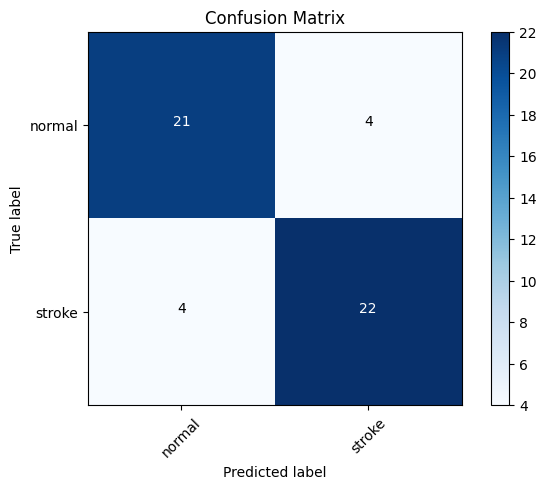

In [29]:
score = models_resnet[2].evaluate(test_batches, verbose=0)

print("Test loss: {}, Test accuracy: {}".format(score[0], score[1]))

predictions = models_resnet[2].predict(x=test_batches, verbose=0)

np.round(predictions)

cm = confusion_matrix(
    y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1)
)

# extract true positives, false positives, true negatives, and false negatives
tn, fp, fn, tp = cm.ravel()

# calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

cm_plot_labels = ["normal", "stroke"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

# SVM ...

In [15]:
rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(train_images, train_labels)
rbf_pred = rbf.predict(test_images)
svm_score = classification_report(test_labels, rbf_pred)
rbf_accuracy = accuracy_score(test_labels, rbf_pred)
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print(svm_score)

ValueError: The number of classes has to be greater than one; got 1 class

In [ ]:
np.round(rbf_pred)

cm = confusion_matrix(
    y_true=test_labels, y_pred=np.argmax(rbf_pred, axis=-1)
)

# extract true positives, false positives, true negatives, and false negatives
tn, fp, fn, tp = cm.ravel()

# calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

cm_plot_labels = ["normal", "stroke"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

# ... and Grid Search version of the SVM

In [ ]:
rbf = svm.SVC(kernel='rbf')
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(rbf, param_grid, cv=5)
grid_search.fit(train_images, train_labels)

# Evaluate the best model on the validation set
best_model = grid_search.best_estimator_
valid_pred = best_model.predict(valid_images)
valid_accuracy = accuracy_score(valid_labels, valid_pred)
valid_score = classification_report(valid_labels, valid_pred)

print("Best hyperparameters: ", grid_search.best_params_)
print('Validation accuracy (RBF kernel): ', "%.2f" % (valid_accuracy*100))
print(valid_score)

# Evaluate the best model on the test set
test_pred = best_model.predict(test_images)
test_accuracy = accuracy_score(test_labels, test_pred)
test_score = classification_report(test_labels, test_pred)

print('Test accuracy (RBF kernel): ', "%.2f" % (test_accuracy*100))
print(test_score)

In [ ]:
np.round(test_pred)

cm = confusion_matrix(
    y_true=test_labels, y_pred=np.argmax(test_pred, axis=-1)
)

# extract true positives, false positives, true negatives, and false negatives
tn, fp, fn, tp = cm.ravel()

# calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

cm_plot_labels = ["normal", "stroke"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")